# Dataiku Technical Assessment - US Census Income Modelling

In [60]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, f1_macro

pd.options.display.max_columns = 50
import warnings
warnings.filterwarnings(action='ignore')#, message='Data with input dtype int64 was converted to float64 by StandardScaler.')

In [21]:
us_census_train = pd.read_csv('us_census_full/census_income_learn.csv', 
                              header = None, skipinitialspace = True, na_values= 'Not in universe')
us_census_test = pd.read_csv('us_census_full/census_income_test.csv', 
                              header = None, skipinitialspace = True, na_values= 'Not in universe')

In [22]:
with open('us_census_full/census_income_metadata.txt', 'r') as f:
    for lineNo, line in enumerate(f.readlines()):
        print(lineNo, line)

0 | This data was extracted from the census bureau database found at

1 | http://www.census.gov/ftp/pub/DES/www/welcome.html

2 | Donor: Terran Lane and Ronny Kohavi

3 |        Data Mining and Visualization

4 |        Silicon Graphics.

5 |        e-mail: terran@ecn.purdue.edu, ronnyk@sgi.com for questions.

6 |

7 | The data was split into train/test in approximately 2/3, 1/3

8 | proportions using MineSet's MIndUtil mineset-to-mlc.

9 |

10 | Prediction task is to determine the income level for the person

11 | represented by the record.  Incomes have been binned at the $50K

12 | level to present a binary classification problem, much like the

13 | original UCI/ADULT database.  The goal field of this data, however,

14 | was drawn from the "total person income" field rather than the

15 | "adjusted gross income" and may, therefore, behave differently than the

16 | orginal ADULT goal field.

17 |

18 | More information detailing the meaning of the attributes can be

19 | found in 

In [23]:
columns = []
with open('us_census_full/census_income_metadata.txt', 'r') as f:
    for lineNo, line in enumerate(f.readlines()):
        if lineNo > 141:
            featureName = line.split(':')[0]
            featureName = featureName.replace(' ', '_')
            columns.append(featureName)
    print(columns)

['age', 'class_of_worker', 'detailed_industry_recode', 'detailed_occupation_recode', 'education', 'wage_per_hour', 'enroll_in_edu_inst_last_wk', 'marital_stat', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_stat', 'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat', 'detailed_household_summary_in_household', '|_instance_weight', 'instance_weight', 'migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self', 'citizenship', 'own_business_or_self_employed', "fill_inc_questionnaire_for_veteran's_admin", 'vete

In [24]:
columns.remove('|_instance_weight')
columns.append('incomeBracket')

In [25]:
try:
    assert(len(columns) == len(us_census_train.columns) == len(us_census_test.columns))
    us_census_train.columns = columns
    us_census_test.columns = columns
except:
    print('Number of column names does not match number of columns in either training or test DataFrames')

In [26]:
us_census_train.head(50)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,instance_weight,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,incomeBracket
0,73,NaN,0,0,High school graduate,0,NaN,Widowed,Not in universe or children,NaN,White,All other,Female,NaN,NaN,Not in labor force,0,0,0,Nonfiler,NaN,NaN,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,NaN,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,NaN,Divorced,Construction,Precision production craft & repair,White,All other,Male,NaN,NaN,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,NaN,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,94,- 50000.
2,18,NaN,0,0,10th grade,0,High school,Never married,Not in universe or children,NaN,Asian or Pacific Islander,All other,Female,NaN,NaN,Not in labor force,0,0,0,Nonfiler,NaN,NaN,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,NaN,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,NaN,2,0,95,- 50000.
3,9,NaN,0,0,Children,0,NaN,Never married,Not in universe or children,NaN,White,All other,Female,NaN,NaN,Children or Armed Forces,0,0,0,Nonfiler,NaN,NaN,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,NaN,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.
4,10,NaN,0,0,Children,0,NaN,Never married,Not in universe or children,NaN,White,All other,Female,NaN,NaN,Children or Armed Forces,0,0,0,Nonfiler,NaN,NaN,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,NaN,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.
5,48,Private,40,10,Some college but no degree,1200,NaN,Married-civilian spouse present,Entertainment,Professional specialty,Amer Indian Aleut or Eskimo,All other,Female,No,NaN,Full-time schedules,0,0,0,Joint both under 65,NaN,NaN,Spouse of householder,Spouse of householder,162.61,?,?,?,Not in universe under 1 year old,?,1,NaN,Philippines,United-States,United-States,Native- Born in the United States,2,NaN,2,52,95,- 50000.
6,42,Private,34,3,Bachelors degree(BA AB BS),0,NaN,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,White,All other,Male,NaN,NaN,Children or Armed Forces,5178,0,0,Joint both under 65,NaN,NaN,Householder,Householder,1535.86,Nonmover,Nonmover,Nonmover,Yes,NaN,6,NaN,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,94,- 50000.
7,28,Private,4,40,High school graduate,0,NaN,Never married,Construction,Handlers equip cleaners etc,White,All other,Female,NaN,Job loser - on layoff,Unemployed full-time,0,0,0,Single,NaN,NaN,Secondary individual,Nonrelative of householder,898.83,?,?,?,Not in universe under 1 year old,?,4,NaN,United-States,United-States,United-

## Data Cleaning

In [27]:
us_census_train['binaryIncome'] = (us_census_train['incomeBracket'] == '50000+.').astype(int)
us_census_train.drop('incomeBracket', axis=1, inplace=True)

us_census_test['binaryIncome'] = (us_census_test['incomeBracket'] == '50000+.').astype(int)
us_census_test.drop('incomeBracket', axis=1, inplace=True)

In [28]:
us_census_train.describe(include='all')

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,instance_weight,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,binaryIncome
count,199523.000000,99278,199523.000000,199523.000000,199523,199523.000000,12580,199523,199523,98839,199523,198649,199523,19064,6070,199523,199523.00000,199523.000000,199523.000000,199523,15773,15773,199523,199523,199523.000000,198007,198007,198007,199523,115469,199523.000000,55291,199523,199523,199523,199523,199523.000000,1984,199523.000000,199523.000000,199523.000000,199523.000000
unique,NaN,8,NaN,NaN,17,NaN,2,7,24,14,5,9,2,2,5,8,NaN,NaN,NaN,6,5,50,38,8,NaN,9,8,9,3,3,NaN,4,43,43,43,5,NaN,2,NaN,NaN,NaN,NaN
top,NaN,Private,NaN,NaN,High school graduate,NaN,High school,Never married,Not in universe or children,Adm support including clerical,White,All other,Female,No,Other job loser,Children or Armed Forces,NaN,NaN,NaN,Nonfiler,South,California,Householder,Householder,NaN,?,?,?,Not in universe under 1 year old,?,NaN,Both parents present,United-States,United-States,United-States,Native- Born in the United States,NaN,No,NaN,NaN,NaN,NaN
freq,NaN,72028,NaN,NaN,48407,NaN,6892,86485,100684,14837,167365,171907,103984,16034,2038,123769,NaN,NaN,NaN,75094,4889,1714,53248,75475,NaN,99696,99696,99696,101212,99696,NaN,38983,159163,160479,176989,176992,NaN,1593,NaN,NaN,NaN,NaN
mean,34.494199,NaN,15.352320,11.306556,NaN,55.426908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,434.71899,37.313788,197.529533,NaN,NaN,NaN,NaN,NaN,1740.380269,NaN,NaN,NaN,NaN,NaN,1.956180,NaN,NaN,NaN,NaN,NaN,0.175438,NaN,1.514833,23.174897,94.499672,0.062058
std,22.310895,NaN,18.067129,14.454204,NaN,274.896454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4697.53128,271.896428,1984.163658,NaN,NaN,NaN,NaN,NaN,993.768156,NaN,NaN,NaN,NaN,NaN,2.365126,NaN,NaN,NaN,NaN,NaN,0.553694,NaN,0.851473,24.411488,0.500001,0.241261
min,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,37.870000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,94.000000,0.000000
25%,15.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1061.615000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,0.000000,94.000000,0.000000
50%,33.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1618.310000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,8.000000,94.000000,0.000000
75%,50.000000,NaN,33.000000,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,2188.610000,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,52.000000,95.000000,0.000000


In [29]:
us_census_train = us_census_train.replace('\?', np.nan, regex=True)
us_census_test = us_census_test.replace('\?', np.nan, regex=True)

In [30]:
for col in us_census_train.columns:
    nullPercent = (us_census_train[col].isna().sum()/len(us_census_train[col]))*100
    print('{} : {:.2f}% null'.format(col, nullPercent))

age : 0.00% null
class_of_worker : 50.24% null
detailed_industry_recode : 0.00% null
detailed_occupation_recode : 0.00% null
education : 0.00% null
wage_per_hour : 0.00% null
enroll_in_edu_inst_last_wk : 93.69% null
marital_stat : 0.00% null
major_industry_code : 0.00% null
major_occupation_code : 50.46% null
race : 0.00% null
hispanic_origin : 0.44% null
sex : 0.00% null
member_of_a_labor_union : 90.45% null
reason_for_unemployment : 96.96% null
full_or_part_time_employment_stat : 0.00% null
capital_gains : 0.00% null
capital_losses : 0.00% null
dividends_from_stocks : 0.00% null
tax_filer_stat : 0.00% null
region_of_previous_residence : 92.09% null
state_of_previous_residence : 92.45% null
detailed_household_and_family_stat : 0.00% null
detailed_household_summary_in_household : 0.00% null
instance_weight : 0.00% null
migration_code-change_in_msa : 50.73% null
migration_code-change_in_reg : 50.73% null
migration_code-move_within_reg : 50.73% null
live_in_this_house_1_year_ago : 0.00% 

In [31]:
us_census_train[us_census_train.select_dtypes(['object']).columns] = us_census_train.select_dtypes(['object']).apply(lambda x: x.astype('category'))
us_census_train[['detailed_industry_recode','detailed_occupation_recode','own_business_or_self_employed','veterans_benefits','year']] = us_census_train[['detailed_industry_recode','detailed_occupation_recode','own_business_or_self_employed','veterans_benefits','year']].astype('category')

us_census_test[us_census_test.select_dtypes(['object']).columns] = us_census_test.select_dtypes(['object']).apply(lambda x: x.astype('category'))
us_census_test[['detailed_industry_recode','detailed_occupation_recode','own_business_or_self_employed','veterans_benefits','year']] = us_census_test[['detailed_industry_recode','detailed_occupation_recode','own_business_or_self_employed','veterans_benefits','year']].astype('category')

In [32]:
us_census_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
age                                           199523 non-null int64
class_of_worker                               99278 non-null category
detailed_industry_recode                      199523 non-null category
detailed_occupation_recode                    199523 non-null category
education                                     199523 non-null category
wage_per_hour                                 199523 non-null int64
enroll_in_edu_inst_last_wk                    12580 non-null category
marital_stat                                  199523 non-null category
major_industry_code                           199523 non-null category
major_occupation_code                         98839 non-null category
race                                          199523 non-null category
hispanic_origin                               198649 non-null category
sex                                           

## Data Visualisation

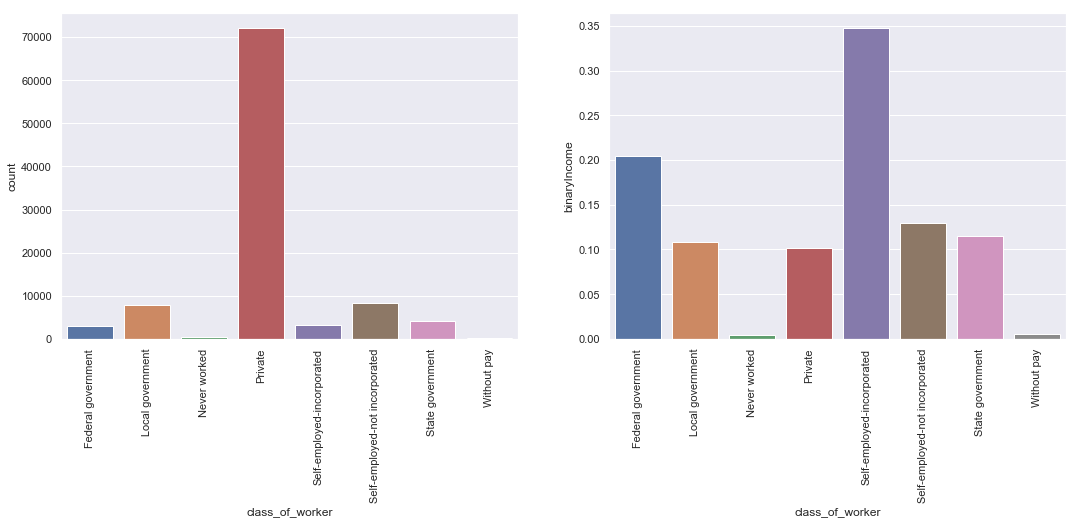

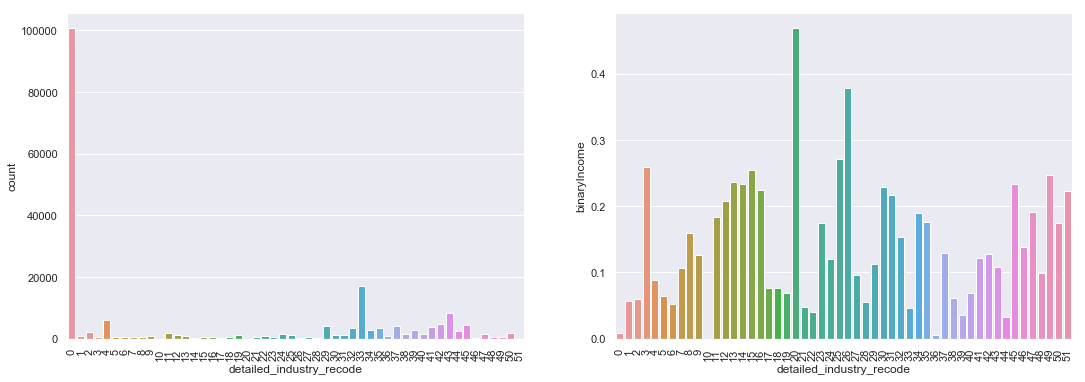

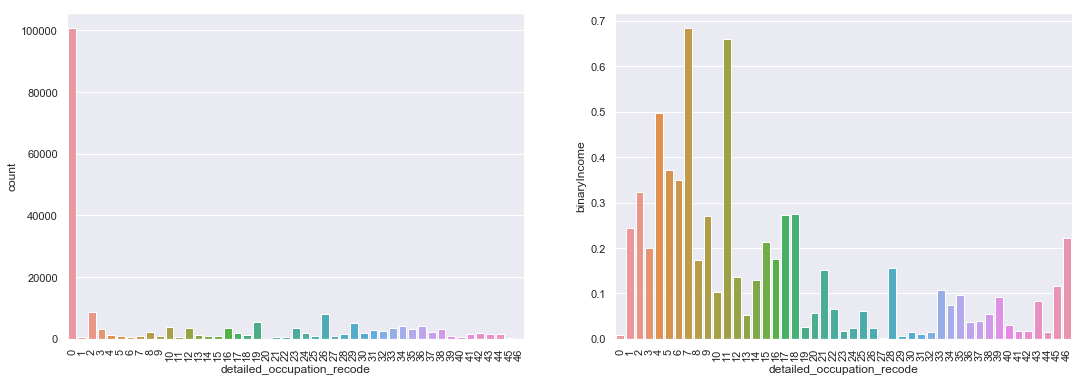

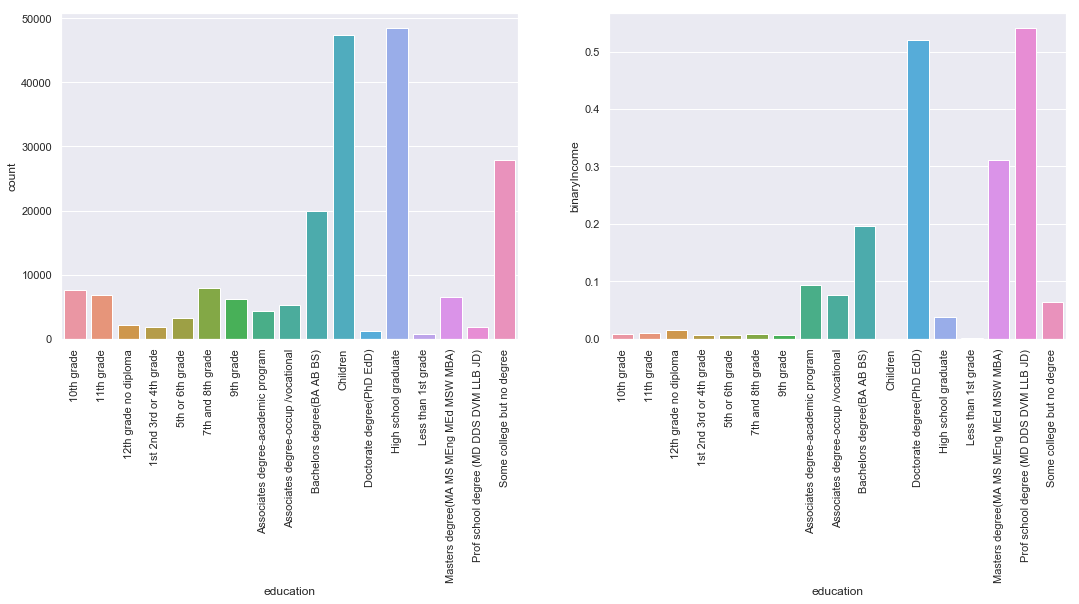

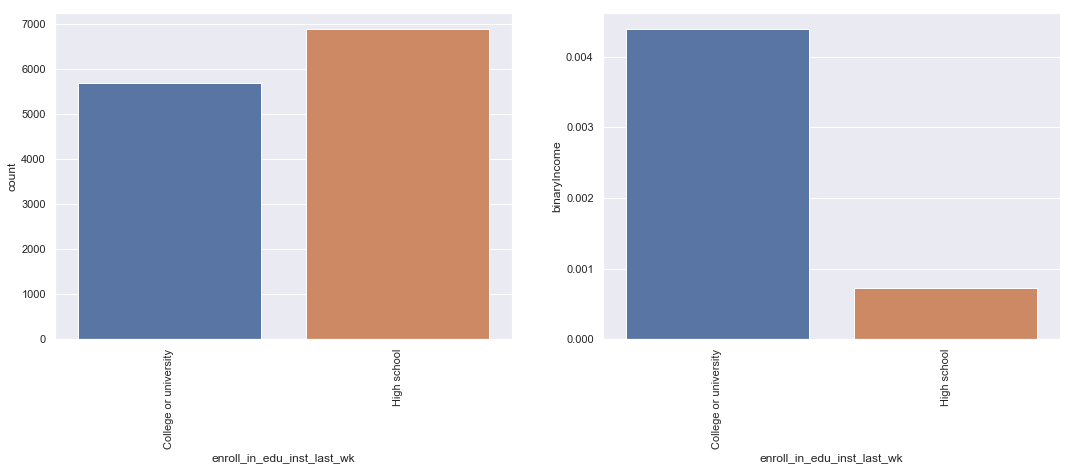

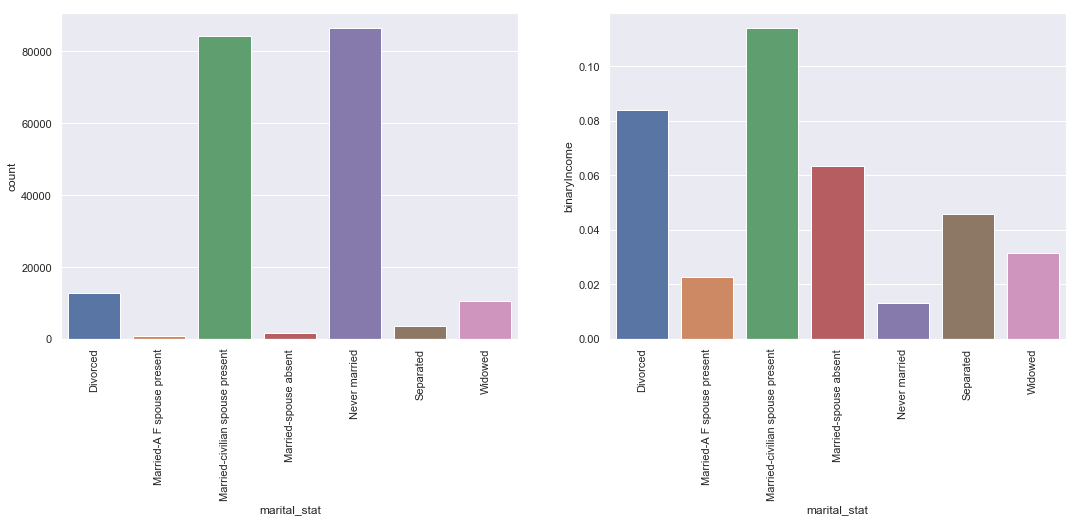

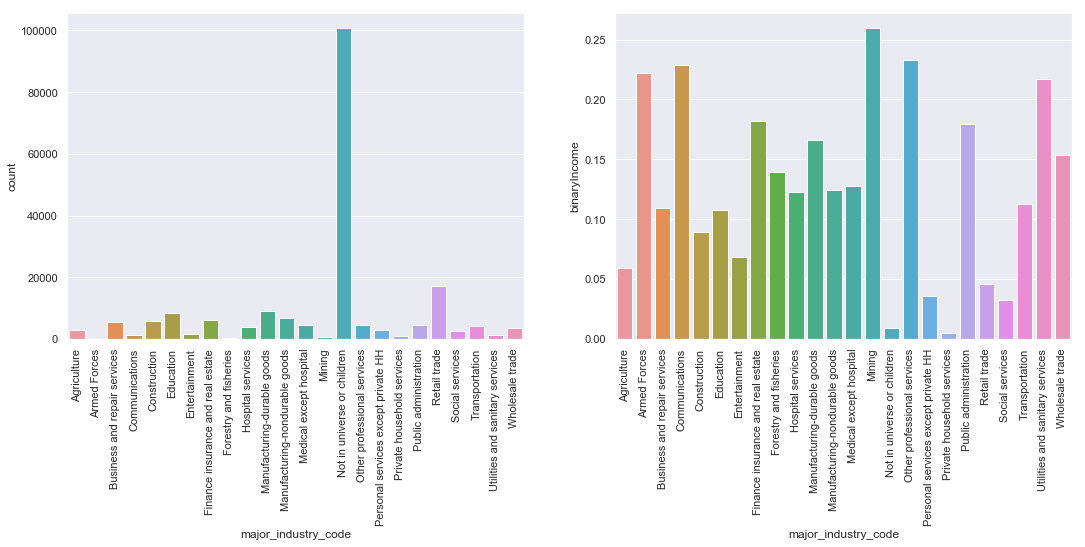

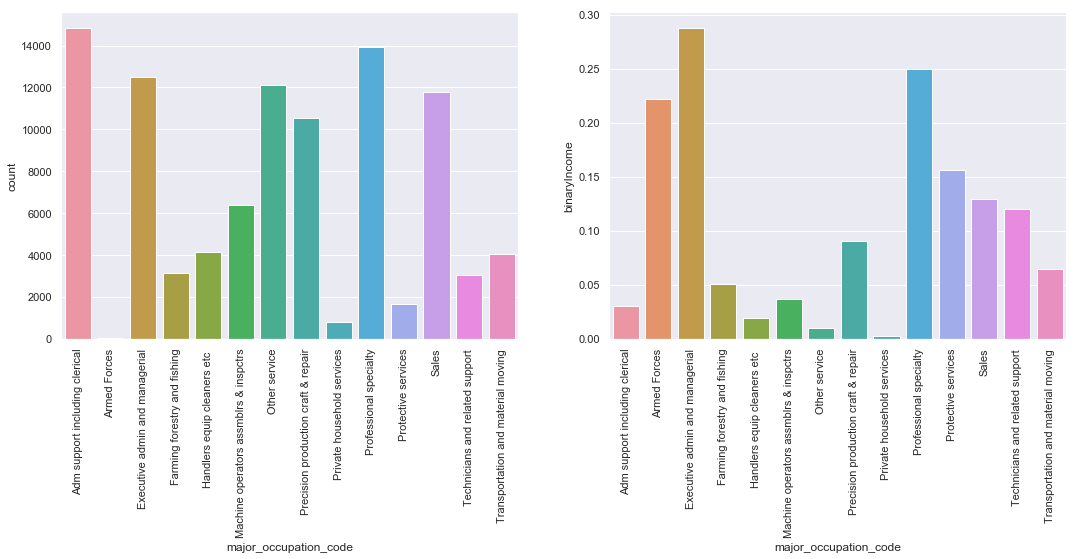

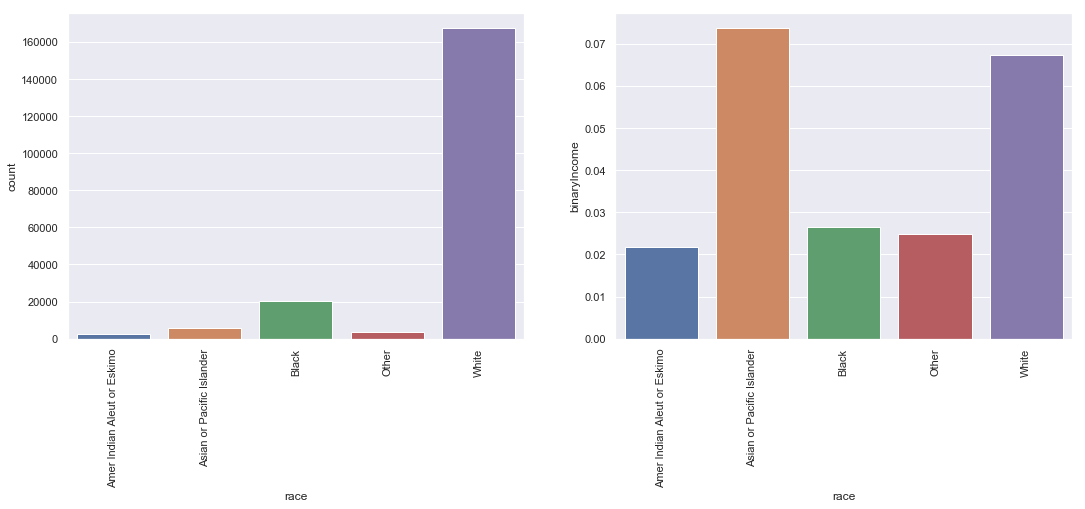

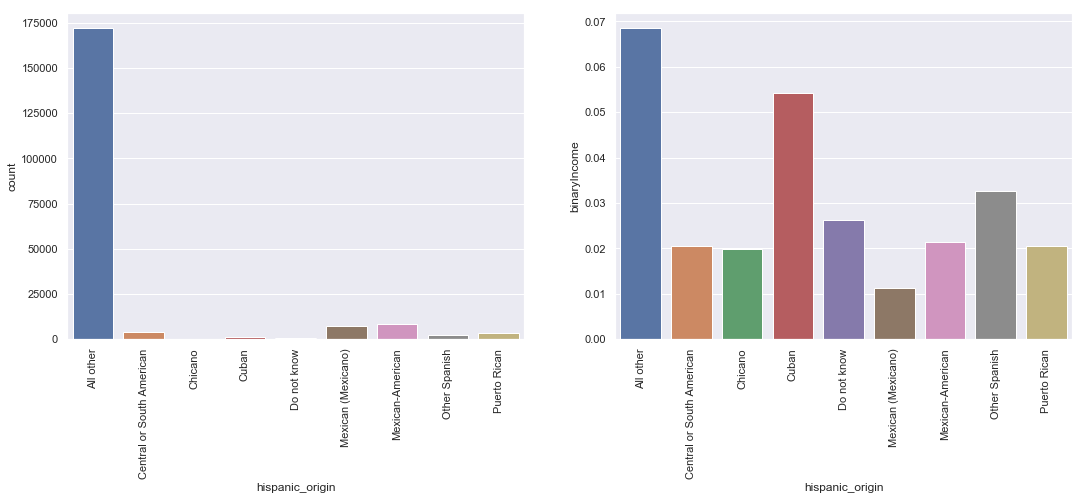

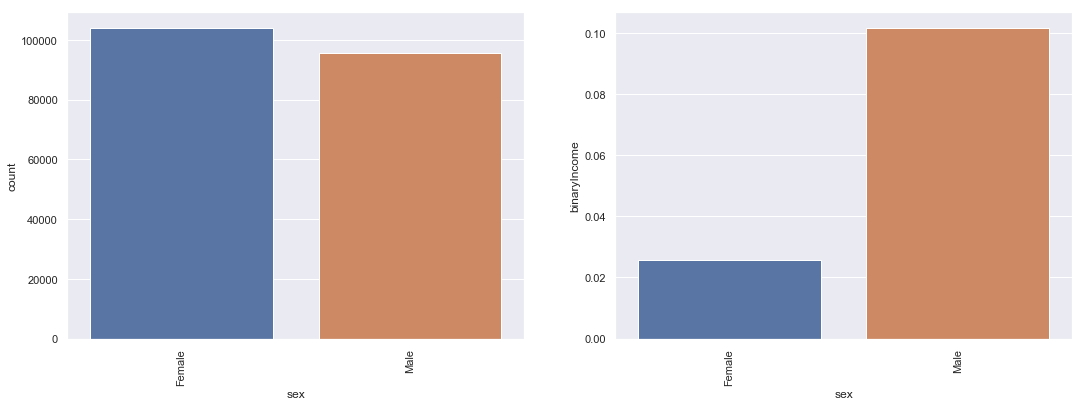

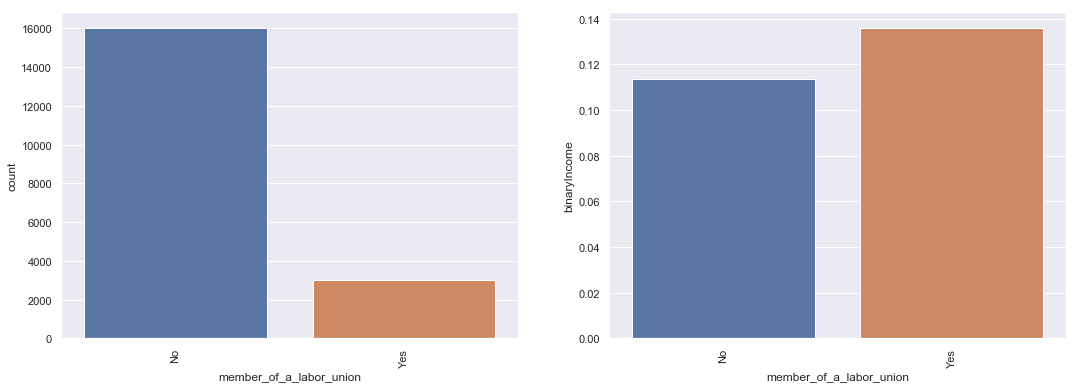

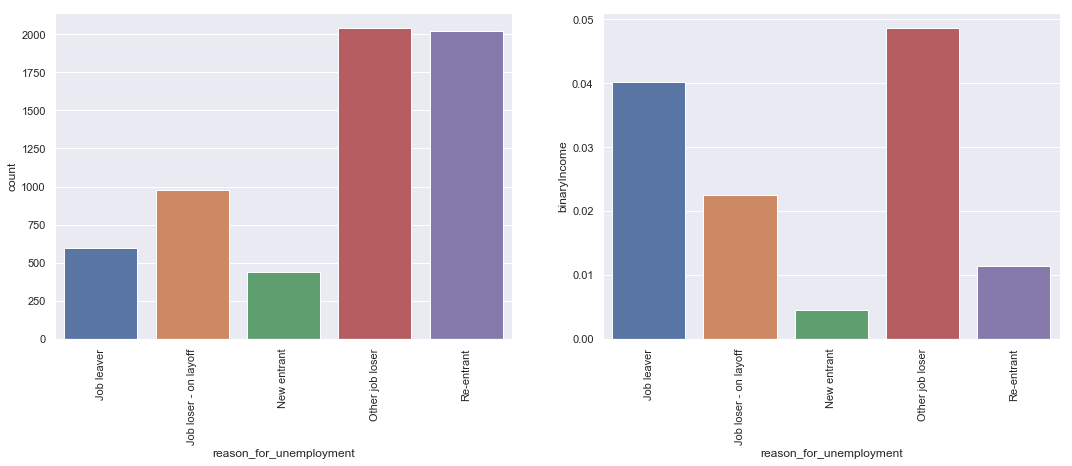

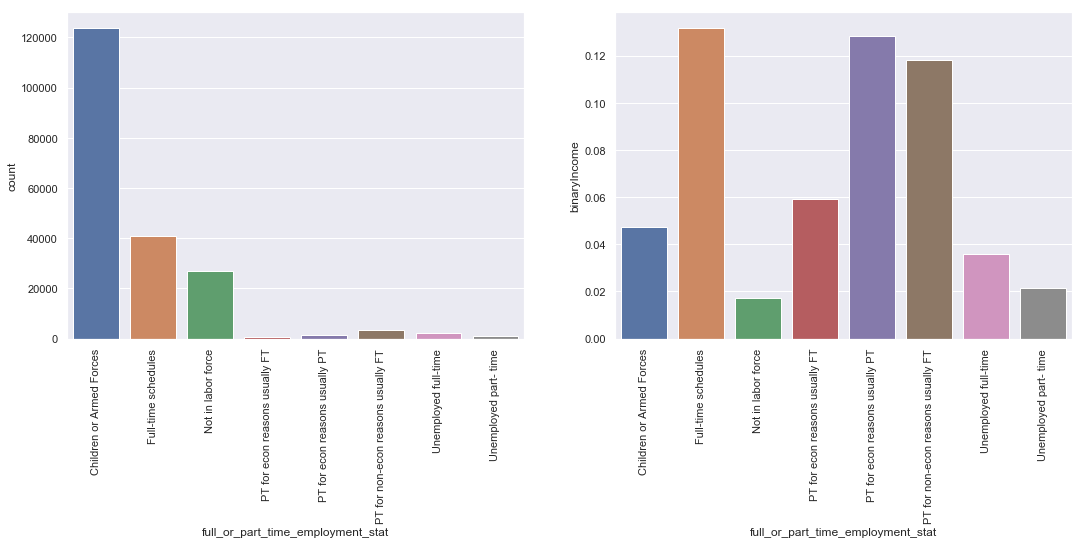

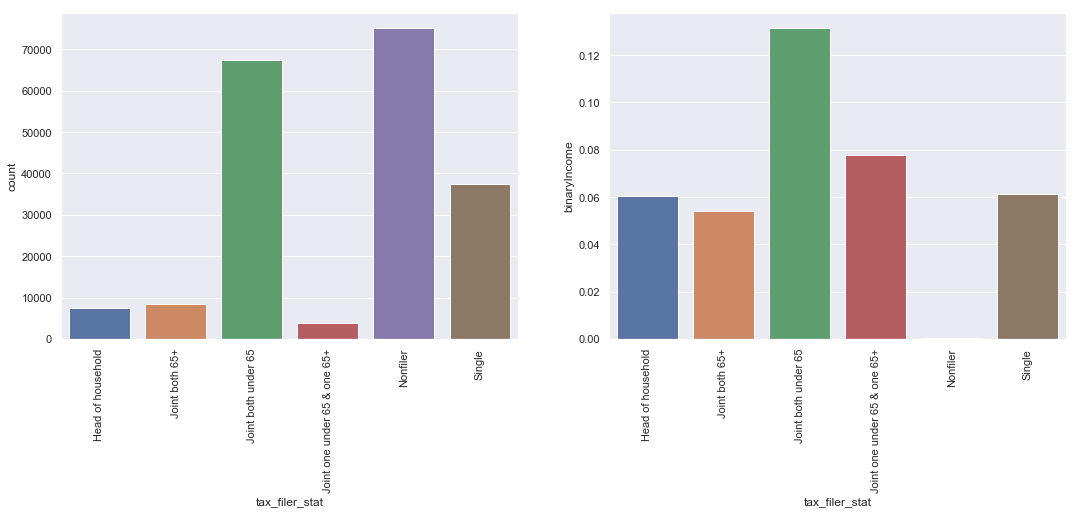

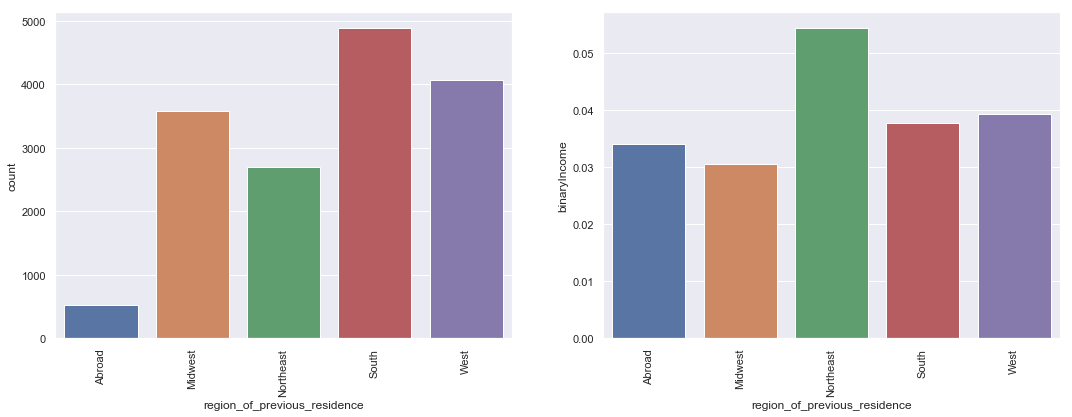

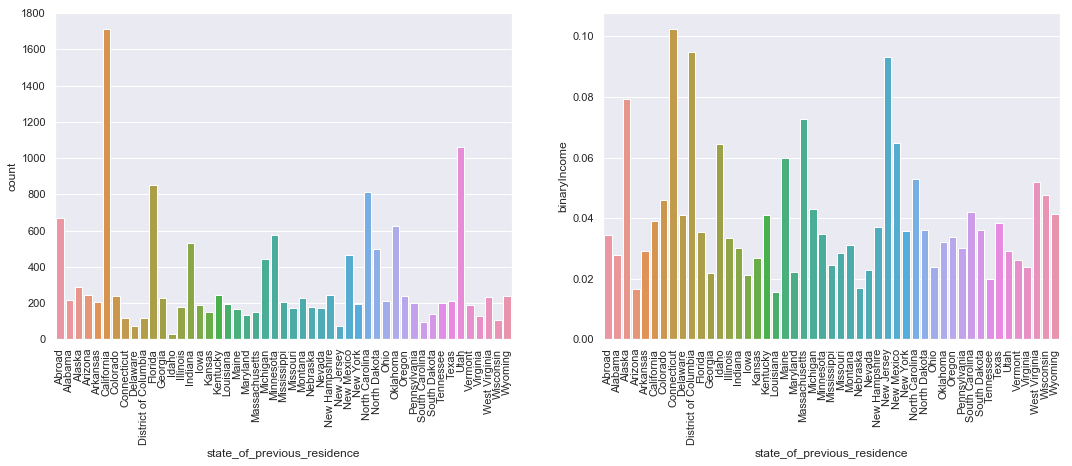

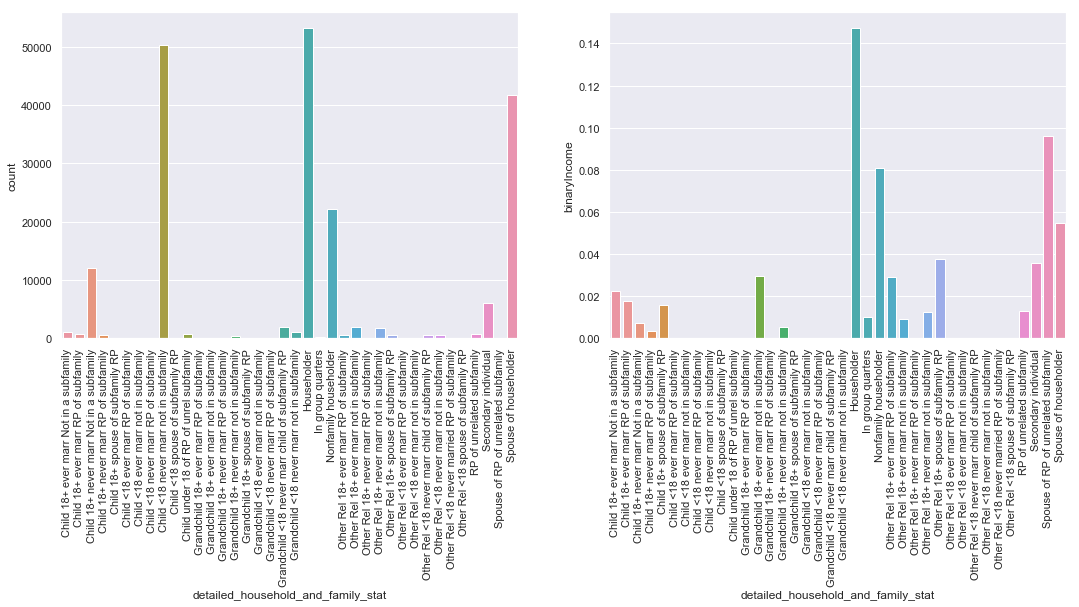

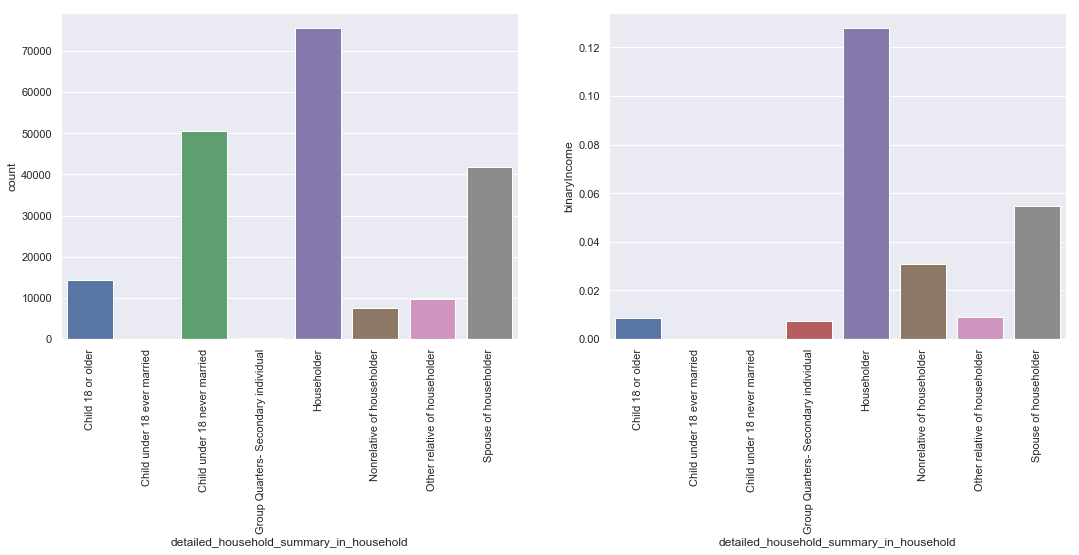

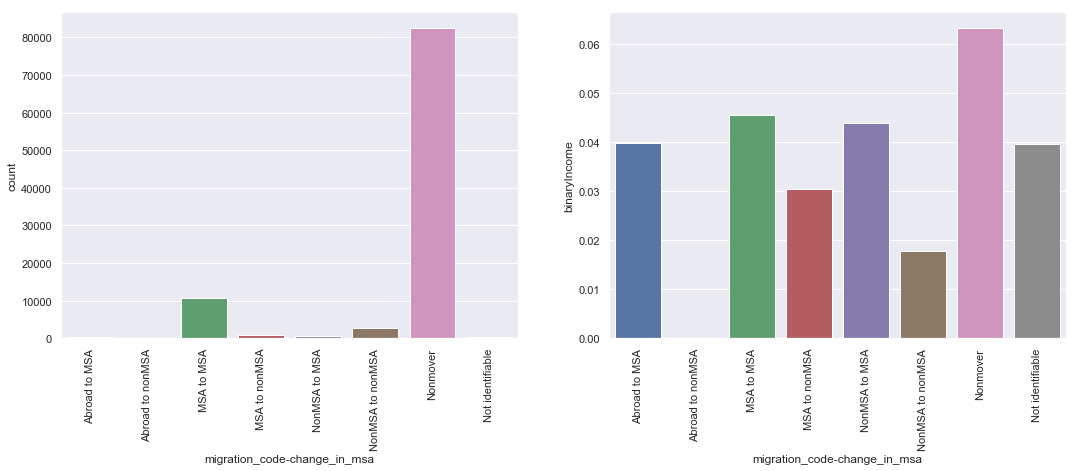

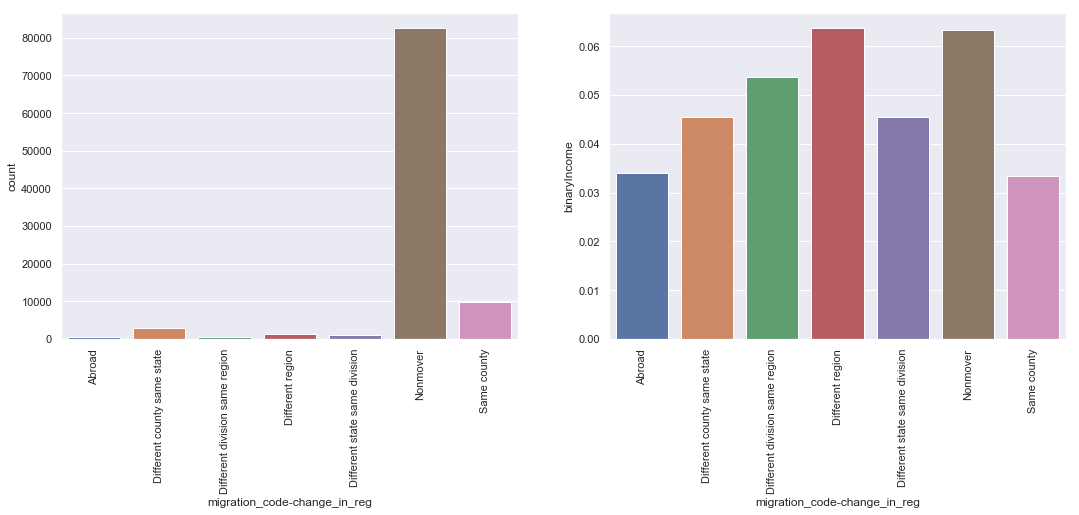

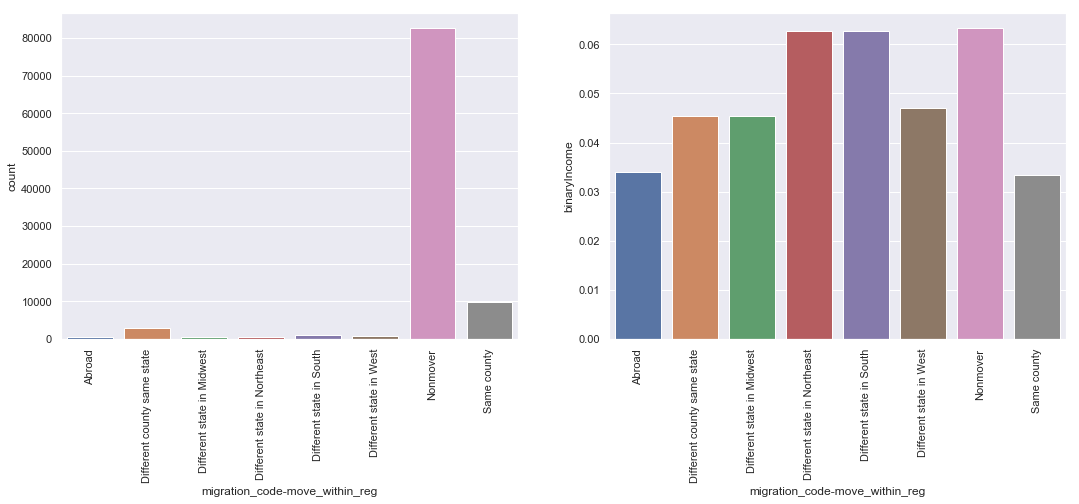

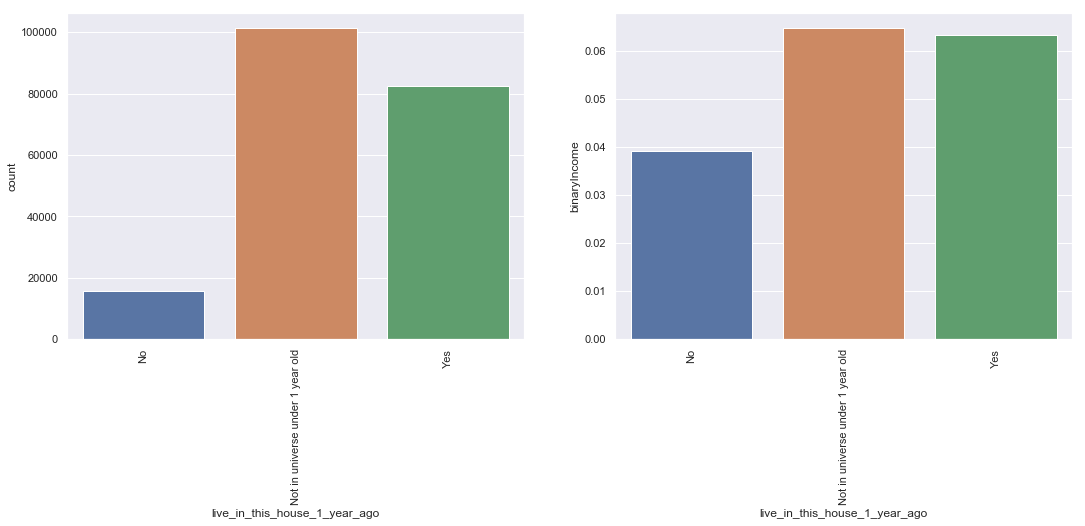

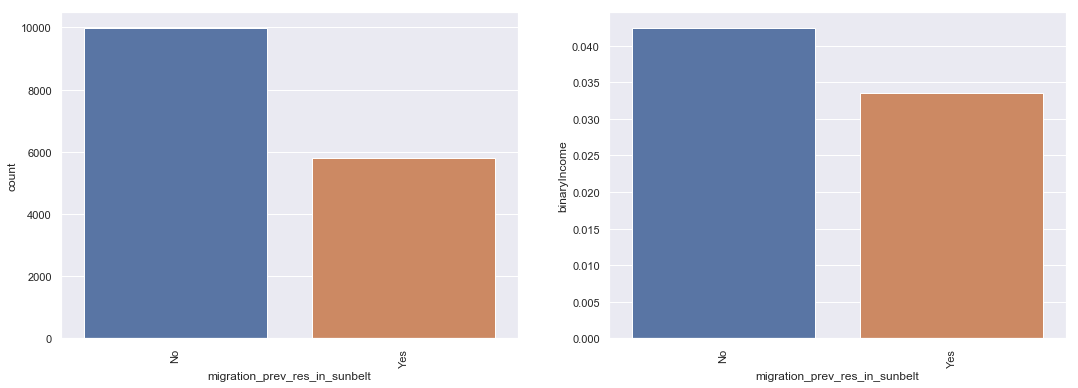

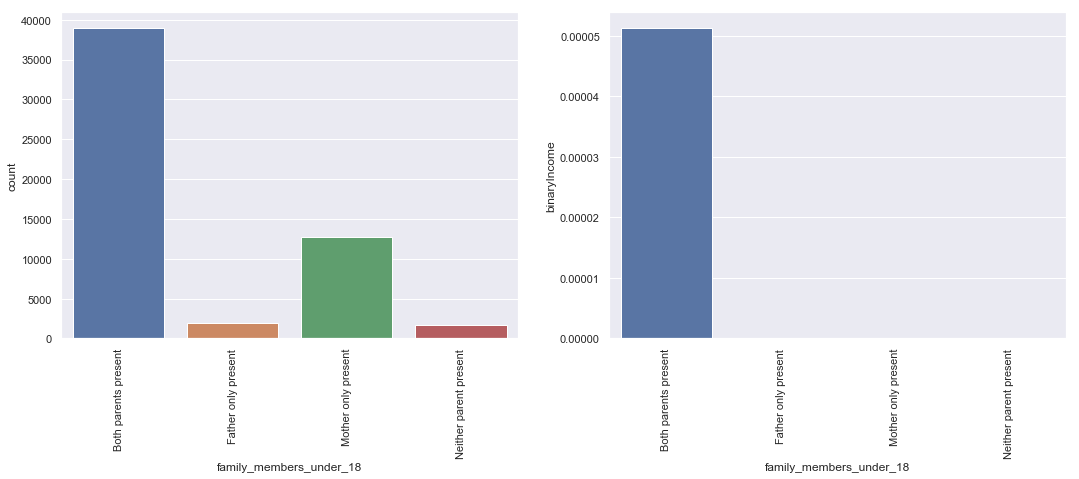

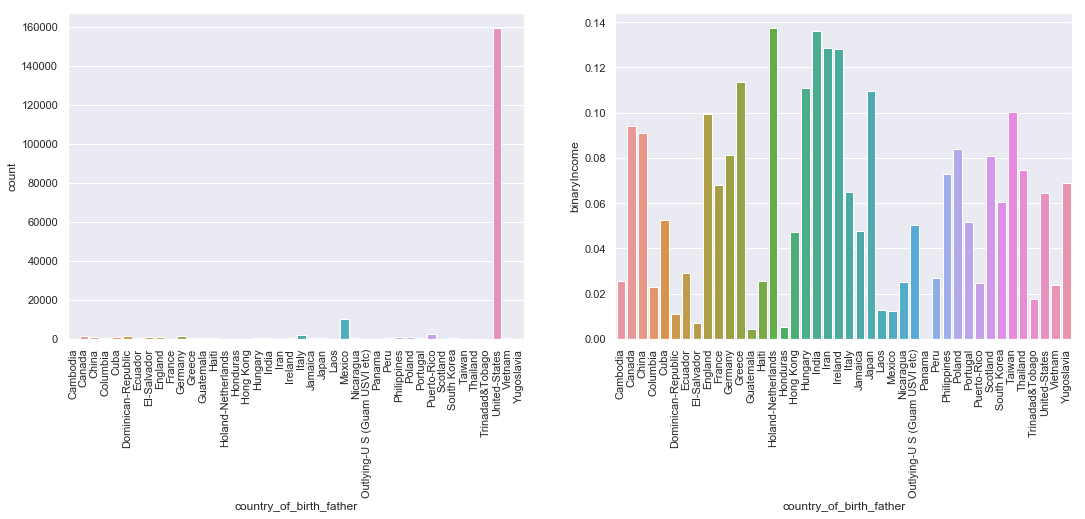

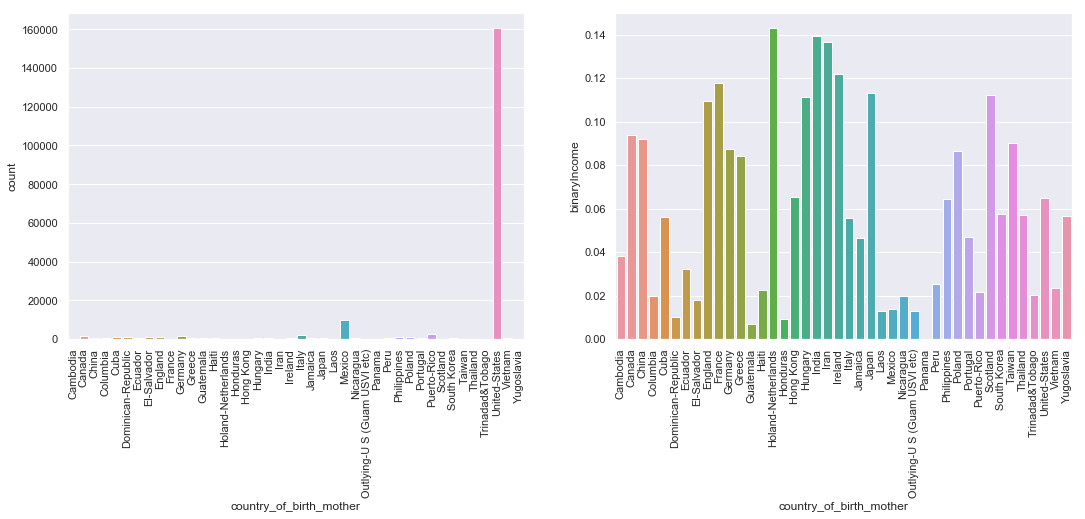

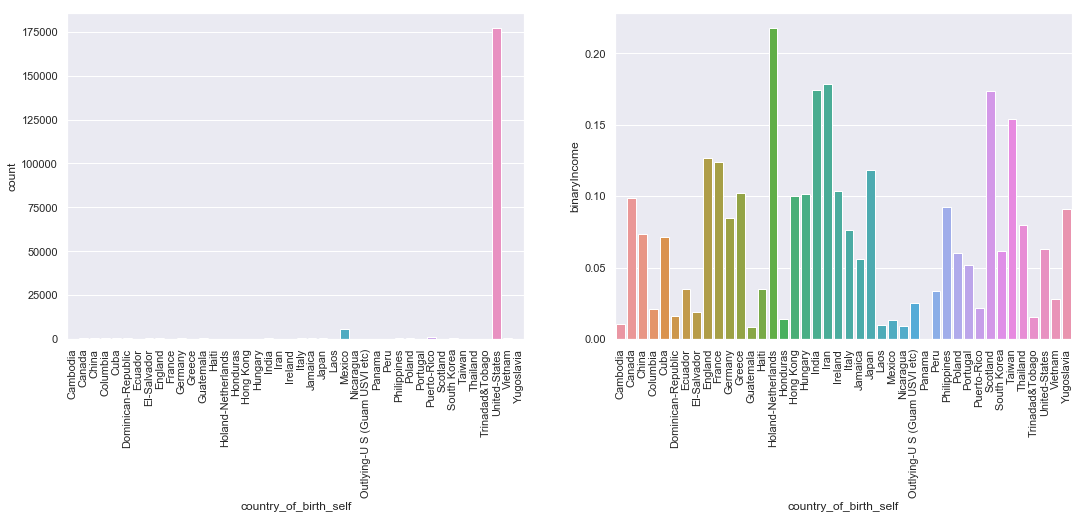

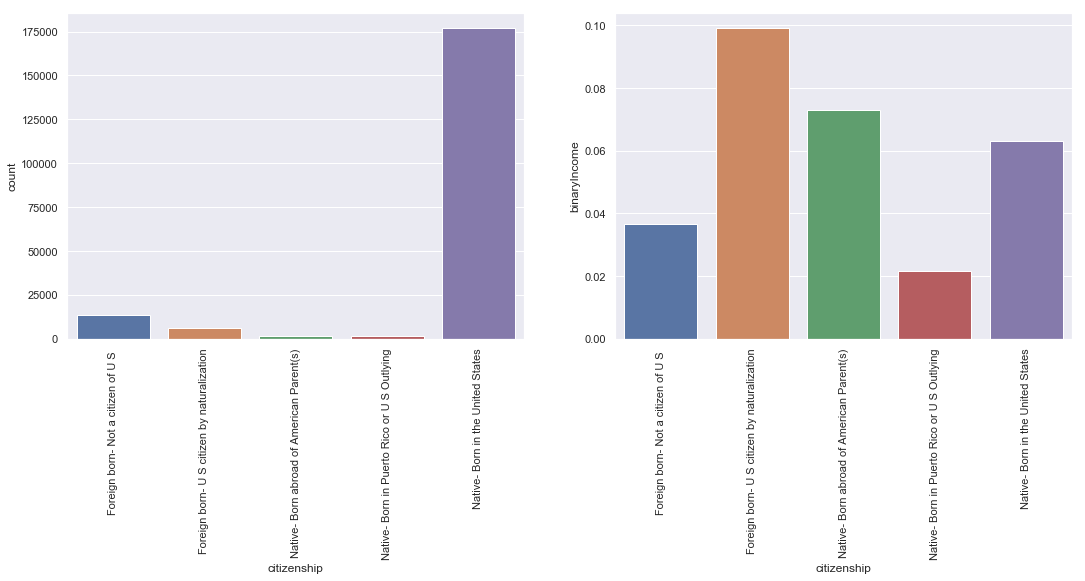

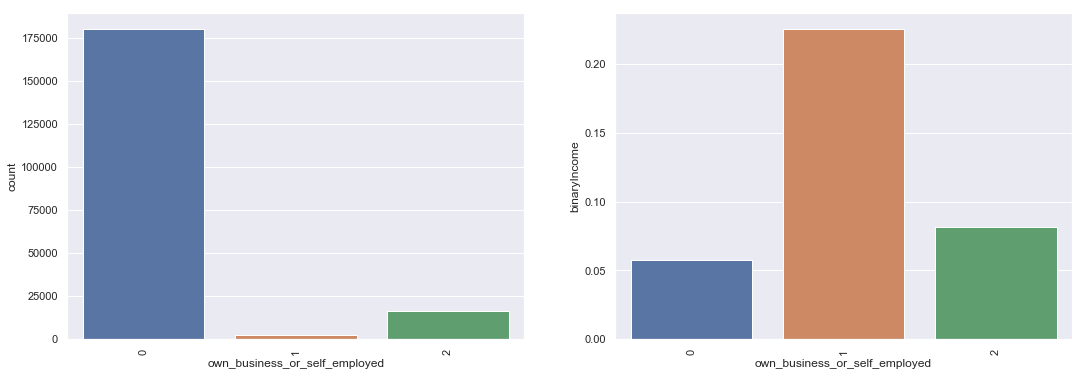

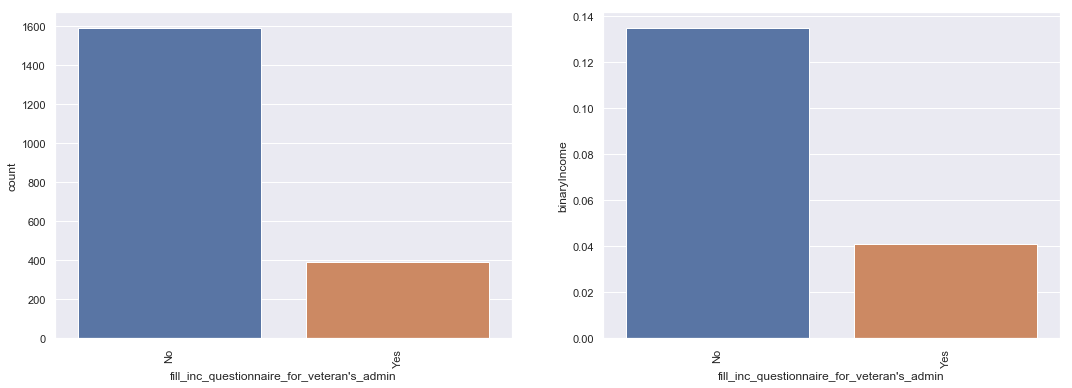

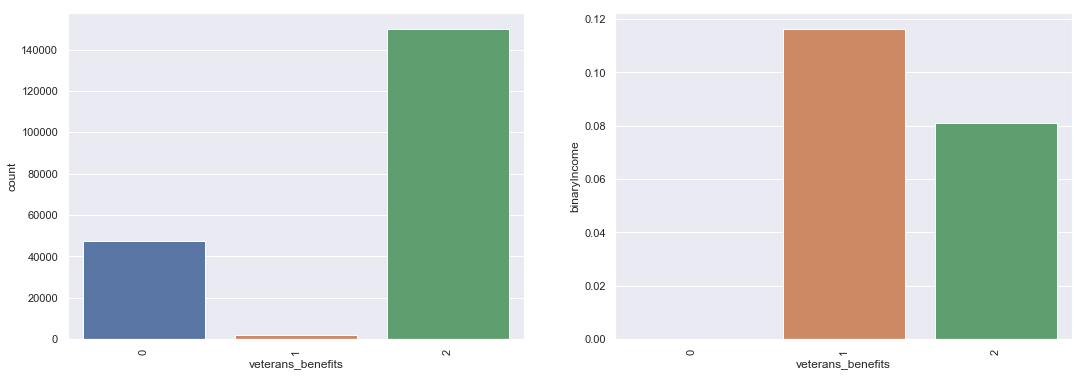

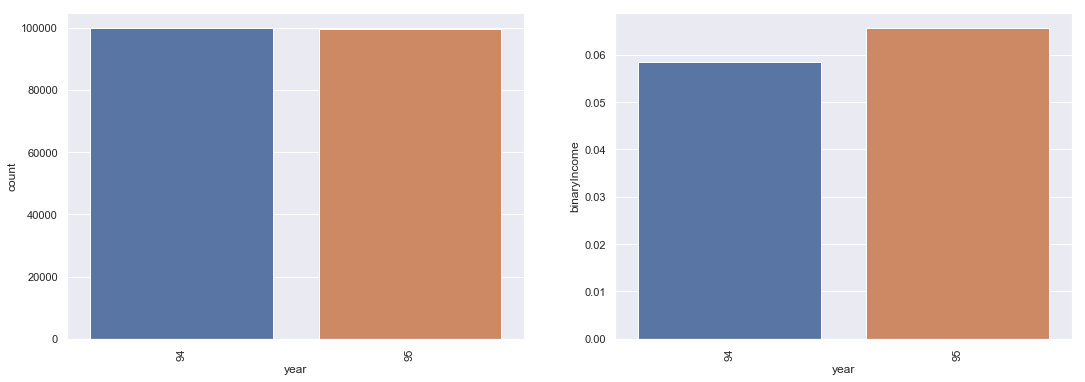

In [33]:
for i, col in enumerate(us_census_train.select_dtypes(['category'])):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    sns.countplot(x = col, data=us_census_train, ax=ax[0])
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    
    incomeByCol = us_census_train.groupby(col)['binaryIncome'].mean().reset_index()
    sns.barplot(x=col, y='binaryIncome', data=incomeByCol, ax=ax[1])
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

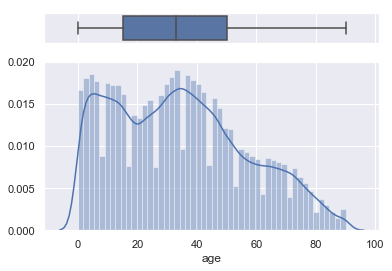

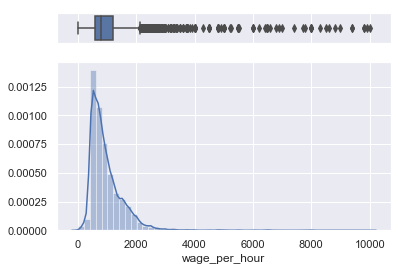

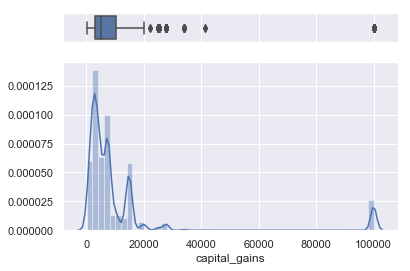

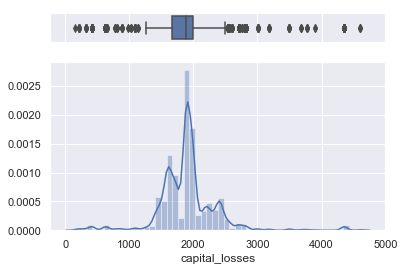

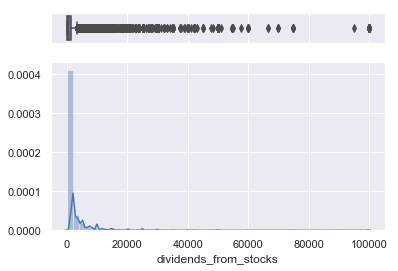

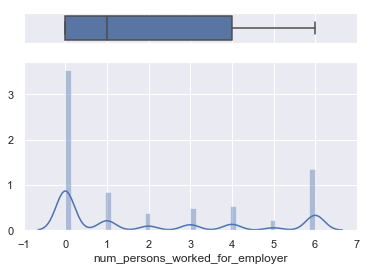

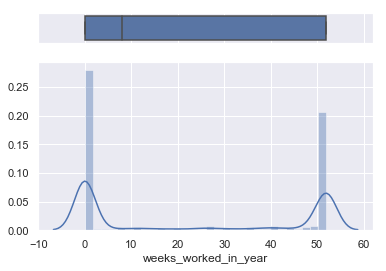

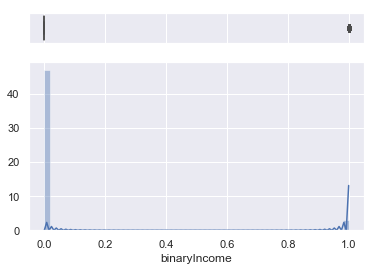

In [69]:
for i, col in enumerate(us_census_train.select_dtypes(['int64'])):
    # Cut the window in 2 parts
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # Add a graph in each part
    if col in ['wage_per_hour', 'capital_gains', 'capital_losses','dividends_from_stocks']:
        sns.boxplot(us_census_train[us_census_train[col]>0][col], ax=ax[0])
        sns.distplot(us_census_train[us_census_train[col]>0][col], ax=ax[1])
    else:
        sns.boxplot(us_census_train[col], ax=ax[0])
        sns.distplot(us_census_train[col], ax=ax[1])

    # Remove x axis name for the boxplot
    ax[0].set(xlabel='')

## Modelling Income

In [80]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()

assert sorted(us_census_train.columns) == sorted(us_census_test.columns)

for col in us_census_train:
    try:
        if col == 'binaryIncome':
            X_train_col = pd.DataFrame(us_census_train[col], columns=[str(col)])
            X_test_col = pd.DataFrame(us_census_test[col], columns=[str(col)])
        elif us_census_train[col].dtype.name == 'int64' or us_census_train[col].dtype.name == 'float64':
            scaler = StandardScaler(with_mean=False)
            X_train_col = pd.DataFrame(scaler.fit_transform(np.array(us_census_train[col]).reshape(-1,1)), columns=[str(col)+'_scaled'])
            X_test_col = pd.DataFrame(scaler.transform(np.array(us_census_test[col]).reshape(-1,1)), columns=[str(col)+'_scaled'])
        elif us_census_train[col].dtype.name == 'category':
            X_train_col = pd.get_dummies(us_census_train[col], prefix=str(col))
            X_test_col = pd.get_dummies(us_census_test[col], prefix=str(col))
        else:
            print('Column {} not of appropriate type'.format(col))
        if sorted(X_train_col.columns) != sorted(X_test_col.columns):
            for newTrainCol in X_train_col:
                if newTrainCol not in X_test_col.columns:
                    X_test_col[newTrainCol] = 0
            for newTestCol in X_test_col:
                if newTestCol not in X_test_col.columns:
                    X_train_col[newTestCol] = 0
        X_train = pd.concat([X_train, X_train_col], axis=1)
        X_test = pd.concat([X_test, X_test_col], axis=1)
    except:
        print("Exception on column {}: {}".format(col, sys.exc_info()[0]))

X_train.describe(include='all')

,age_scaled,class_of_worker_Federal government,class_of_worker_Local government,class_of_worker_Never worked,class_of_worker_Private,class_of_worker_Self-employed-incorporated,class_of_worker_Self-employed-not incorporated,class_of_worker_State government,class_of_worker_Without pay,detailed_industry_recode_0,detailed_industry_recode_1,detailed_industry_recode_2,detailed_industry_recode_3,detailed_industry_recode_4,detailed_industry_recode_5,detailed_industry_recode_6,detailed_industry_recode_7,detailed_industry_recode_8,detailed_industry_recode_9,detailed_industry_recode_10,detailed_industry_recode_11,detailed_industry_recode_12,detailed_industry_recode_13,detailed_industry_recode_14,detailed_industry_recode_15,...,country_of_birth_self_Scotland,country_of_birth_self_South Korea,country_of_birth_self_Taiwan,country_of_birth_self_Thailand,country_of_birth_self_Trinadad&Tobago,country_of_birth_self_United-States,country_of_birth_self_Vietnam,country_of_birth_self_Yugoslavia,citizenship_Foreign born- Not a citizen of U S,citizenship_Foreign born- U S citizen by naturalization,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States,own_business_or_self_employed_0,own_business_or_self_employed_1,own_business_or_self_employed_2,fill_inc_questionnaire_for_veteran's_admin_No,fill_inc_questionnaire_for_veteran's_admin_Yes,veterans_benefits_0,veterans_benefits_1,veterans_benefits_2,weeks_worked_in_year_scaled,year_94,year_95,binaryIncome
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,...,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,1.546074,0.014660,0.039013,0.002200,0.361001,0.016364,0.042326,0.021186,0.000827,0.504624,0.004145,0.011006,0.002822,0.029992,0.002772,0.002777,0.002115,0.002757,0.004977,0.000020,0.008841,0.006766,0.004506,0.001479,0.002265,...,0.000376,0.002361,0.001007,0.000566,0.000331,0.887061,0.001960,0.000331,0.067165,0.029345,0.008801,0.007613,0.887076,0.905520,0.013522,0.080958,0.007984,0.001960,0.237612,0.009944,0.752445,0.949346,0.500328,0.499672,0.062058
std,1.000003,0.120188,0.193626,0.046855,0.480292,0.126871,0.201332,0.144003,0.028745,0.499980,0.064247,0.104332,0.053045,0.170564,0.052573,0.052621,0.045941,0.052431,0.070371,0.004477,0.093611,0.081978,0.066974,0.038423,0.047542,...,0.019384,0.048529,0.031724,0.023791,0.018185,0.316519,0.044225,0.018185,0.250308,0.168772,0.093400,0.086921,0.316501,0.292497,0.115497,0.272771,0.088996,0.044225,0.425621,0.099221,0.431593,1.000003,0.500001,0.500001,0.241261
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.672319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0

In [81]:
y_train = X_train['binaryIncome']
y_test = X_test['binaryIncome']

X_train.drop('binaryIncome', axis=1, inplace=True)
X_test.drop('binaryIncome', axis=1, inplace=True)
X_train.drop('instance_weight_scaled', axis=1, inplace=True)
X_test.drop('instance_weight_scaled', axis=1, inplace=True)

In [82]:
skb = SelectPercentile(score_func = chi2, percentile=10)
X_train_reduced = skb.fit_transform(X_train, y_train)

mask = skb.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X_train.columns):
    if bool:
        new_features.append(feature)
        
X_train_reduced = pd.DataFrame(X_train_reduced, columns = new_features)
X_test_reduced = X_test.loc[:,new_features]
X_train_reduced.head()

,age_scaled,class_of_worker_Federal government,class_of_worker_Private,class_of_worker_Self-employed-incorporated,detailed_industry_recode_0,detailed_industry_recode_45,detailed_occupation_recode_0,detailed_occupation_recode_2,detailed_occupation_recode_3,detailed_occupation_recode_4,detailed_occupation_recode_5,detailed_occupation_recode_7,detailed_occupation_recode_11,detailed_occupation_recode_17,education_Bachelors degree(BA AB BS),education_Children,education_Doctorate degree(PhD EdD),education_Masters degree(MA MS MEng MEd MSW MBA),education_Prof school degree (MD DDS DVM LLB JD),marital_stat_Married-civilian spouse present,marital_stat_Never married,major_industry_code_Finance insurance and real estate,major_industry_code_Manufacturing-durable goods,major_industry_code_Not in universe or children,major_industry_code_Other professional services,major_industry_code_Public administration,major_occupation_code_Executive admin and managerial,major_occupation_code_Professional specialty,major_occupation_code_Sales,sex_Female,sex_Male,full_or_part_time_employment_stat_Full-time schedules,full_or_part_time_employment_stat_Not in labor force,capital_gains_scaled,capital_losses_scaled,dividends_from_stocks_scaled,tax_filer_stat_Joint both under 65,tax_filer_stat_Nonfiler,detailed_household_and_family_stat_Child <18 never marr not in subfamily,detailed_household_and_family_stat_Householder,detailed_household_summary_in_household_Child under 18 never married,detailed_household_summary_in_household_Householder,num_persons_worked_for_employer_scaled,family_members_under_18_Both parents present,family_members_under_18_Mother only present,own_business_or_self_employed_1,veterans_benefits_0,veterans_benefits_2,weeks_worked_in_year_scaled
0,3.271952,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.00000
1,2.599633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.422812,0.0,0.0,0.0,0.0,1.0,2.13015
2,0.806783,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.00000
3,0.403391,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,1.0,0.0,0.0,1.0,0.0,0.00000
4,0.448213,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,1.0,0.0,0.0,1.0,0.0,0.00000


In [38]:
"""
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X_train_reduced, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
"""

'\n# Create the RFE object and compute a cross-validated score.\nsvc = SVC(kernel="linear")\n# The "accuracy" scoring is proportional to the number of correct\n# classifications\nrfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),\n              scoring=\'accuracy\')\nrfecv.fit(X_train_reduced, y_train)\n\nprint("Optimal number of features : %d" % rfecv.n_features_)\n\n# Plot number of features VS. cross-validation scores\nplt.figure()\nplt.xlabel("Number of features selected")\nplt.ylabel("Cross validation score (nb of correct classifications)")\nplt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)\nplt.show()\n'

In [83]:
logReg = LogisticRegression()
logReg.fit(X_train_reduced, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [84]:
#CV_accuracy = np.mean(cross_val_score(logReg, X_train_reduced, y_train, cv=5))
CV_F1 = np.mean(cross_val_score(logReg, X_train_reduced, y_train, cv=5, scoring = 'f1_macro'))
CV_F1

0.7329080375720296

In [50]:
# Calcuate prediction accuracy
y_pred_logReg = logReg.predict(X_test_reduced)
print(accuracy_score(y_test, y_pred_logReg))

0.9523967041558911


In [53]:
(len(y_test)-sum(y_test))/len(y_test)

0.937992421964275

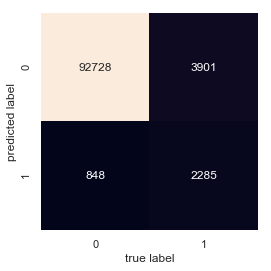

In [55]:
# Create confusion matrix
mat = confusion_matrix(y_test, y_pred_logReg)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [57]:
print(classification_report(y_test, y_pred_logReg))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     93576
           1       0.73      0.37      0.49      6186

   micro avg       0.95      0.95      0.95     99762
   macro avg       0.84      0.68      0.73     99762
weighted avg       0.95      0.95      0.94     99762



In [59]:
print(f1_score(y_test, y_pred_logReg))

0.49039596523232104
